<a href="https://colab.research.google.com/github/emerson-matos/tcc-notebooks/blob/main/reviews/analise_exploratoria_2018%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monta o google drive

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

from google.colab import drive
sns.color_palette("tab10")
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from google.colab import auth
import gspread
from google.auth import default

auth.authenticate_user()

creds, _ = default()

gc = gspread.authorize(creds)

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Baixe a lista de stopwords em português
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Dados dos hoteis

In [4]:
date = "2023/07/07"

## Cria o DataFrame

### conferindo a versão do sns

In [5]:
ws = gc.open('PGC-hotels')
emerson = ws.worksheet('Emerson')
hotels = pd.DataFrame(emerson.get_all_records())[['name', 'stars', 'overall_rating', 'region', 'state', 'qtd_reviews', 'source']]

sns.__version__

'0.12.2'

### carregando um unico arquivo

In [6]:
filename = 'grand-oca-maragogi-gm-reviews.csv'
dados = pd.read_csv(f"/content/gdrive/MyDrive/tcc/data/{date}/{filename}")
dados['source'] = filename.split('.')[0]
dados.loc[1]['text']

'De tudo do Resort um serviço superou as minhas expectativas: a Yasmin é uma manicure sensacional, fez muitíssimo bem meu pé e minha mão, nota mil'

### carregando todos os arquivos da pasta

In [6]:
import glob
import os

path_to_lookup = f'/content/gdrive/MyDrive/tcc/data/{date}/'
file_pattern = "*.csv"

# setting the path for joining multiple files
files = os.path.join(path_to_lookup, file_pattern)

# list of merged files returned
files = glob.glob(files)

dados = pd.concat(map(lambda file: pd.read_csv(file).assign(source=file.split("/")[-1].split('-gm-reviews')[0]), files), ignore_index=True)

In [7]:
df = dados[['retrieval_date', 'rating', 'relative_date', 'likes', 'user_is_local_guide', 'text', 'source', 'user_reviews']].copy()

### Tratando dataset

#### preparando colunas

Transformamos a data relativa da realização do review em datetime e criamos novas colunas com partes dessa data e também quantidade de reviews de um usuario em um valor inteiro.

##### definindo transformações

In [8]:
from datetime import datetime, timedelta
import re

def transform_user_reviews(x):
  if isinstance(x, str) and x == 'Um':
    1
  elif isinstance(x, str):
    return int(x.replace('.',''))
  return x

# Função para detectar idioma, tratando valores nulos e textos vazios
def detectar_idioma(texto):
    if texto and len(texto) > 2:  # Verificar se o texto não é nulo e não está vazio
        try:
          lang = detect(texto)
          return lang
        except:
          print(f"deu ruim {texto}")

    return None

def obtem_data(row):
  # String de data relativa
  data_relativa_str = row.relative_date
  timestamp = row.retrieval_date

  # Converte a string em um objeto timedelta
  unidade_tempo = data_relativa_str.split()[1]
  quantidade_tempo = 1 if 'um' in data_relativa_str.split()[0] else int(data_relativa_str.split()[0])

  if 'segundo' in unidade_tempo:
      data_relativa = timedelta(seconds=quantidade_tempo)
  elif 'minuto' in unidade_tempo:
      data_relativa = timedelta(minutes=quantidade_tempo)
  elif 'hora' in unidade_tempo:
      data_relativa = timedelta(hours=quantidade_tempo)
  elif 'dia' in unidade_tempo:
      data_relativa = timedelta(days=quantidade_tempo)
  elif 'semana' in unidade_tempo:
      data_relativa = timedelta(weeks=quantidade_tempo)
  elif re.match(r"m(ê|e)s", unidade_tempo):
      data_relativa = timedelta(days=30*quantidade_tempo)
  elif 'ano' in unidade_tempo:
      data_relativa = timedelta(days=365*quantidade_tempo)
  else:
      return timestamp

  # Timestamp
  try:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f')
  except:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')

  return (dt_timestamp - data_relativa).date()

##### transformações rápidas

In [9]:
df['user_reviews'] = df['user_reviews'].apply(transform_user_reviews).fillna(0)

df['data_avaliacao'] = pd.to_datetime(df.apply(obtem_data, axis=1))

# Extract month and year from the 'date' column
df['mes_avaliacao'] = df['data_avaliacao'].dt.month
df['ano_avaliacao'] = df['data_avaliacao'].dt.year

# Create a new column representing the combination of month and year
df['mes_ano_avaliacao'] = df['data_avaliacao'].dt.to_period('M')

##### contagem de avaliações por ano sem filtros

In [10]:
df['ano_avaliacao'].value_counts()

2022    32396
2023    23082
2019    19060
2020    13786
2018    12625
2021    12397
2017     4426
2016      940
2015      247
2014      106
2013       88
2012        9
2011        5
Name: ano_avaliacao, dtype: int64

##### marcando avaliações que serão analisados

In [11]:
df['com_texto'] = df['text'].notna()
df['analisar'] = (df['text'].str.len() > 2) & (~df['text'].str.contains('Tradução do Google', na=False)) & (df['ano_avaliacao'] > 2017)
df['traduzido'] = df['text'].str.contains('Tradução do Google', na=False)

In [12]:
df[df['analisar']]['ano_avaliacao'].value_counts()

2022    24437
2023    17547
2019     9693
2021     8918
2020     6947
2018     6678
Name: ano_avaliacao, dtype: int64

In [57]:
import unicodedata

filtered_df = df[df['analisar']].copy()

hotels['source_normalized'] = hotels['source'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))
df['source_normalized'] = df['source'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))

hotels_metadados = pd.merge(hotels, df, on="source_normalized")[['name', 'stars', 'overall_rating', 'region', 'state', 'analisar']]

In [58]:
hotels_reviews = hotels_metadados.groupby(['name', 'state', 'stars', 'overall_rating', 'analisar']).agg(counts=('analisar', 'size'))
hotels_reviews['total_counts'] = hotels_reviews.groupby('name')['counts'].transform('sum')

hotels_reviews['percentage'] = hotels_reviews['counts'] / hotels_reviews['total_counts'] * 100

#### quantidade de reviews

##### quantidade total de reviews

In [19]:
df.shape[0] ## reviews no total com e sem texto

119167

##### quantidade de reviews que serão analisados

In [20]:
sum(df['analisar']) / df.shape[0] * 100 ## reviews com texto

62.28234326617268

In [21]:
sum(df['analisar'])

74220

##### quantidade de reviews traduzidos ou com menos de 3 caracteres (2 ou menos)

In [22]:
sum(~df['analisar']) / df.shape[0] * 100

37.71765673382732

In [23]:
sum(~df['analisar'])

44947

##### quantidade de reviews traduzidos e sem texto

In [24]:
sum(df['traduzido']) / df.shape[0] * 100 ## reviews traduzidos

6.403618451416919

In [25]:
sum(df['traduzido'])

7631

In [26]:
sum(~df['com_texto']) / df.shape[0] * 100 ## reviews sem texto

28.37446608540955

In [27]:
sum(~df['com_texto'])

33813

#### exemplo

In [51]:
df.head()

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,analisar,traduzido,source_normalized
0,2023-07-07 00:33:49.380294,5.0,21 horas atrás,0,False,Um dos melhores hoteis all inclusive de Porto ...,hotel-coroa-vermelha-beach-all-inclusive,5,2023-07-06,7,2023,2023-07,True,True,False,hotel-coroa-vermelha-beach-all-inclusive
1,2023-07-07 00:33:49.424589,4.0,um dia atrás,-1,True,NaN,hotel-coroa-vermelha-beach-all-inclusive,5,2023-07-06,7,2023,2023-07,False,False,False,hotel-coroa-vermelha-beach-all-inclusive
2,2023-07-07 00:33:49.442777,5.0,um dia atrás,-1,NaN,NaN,hotel-coroa-vermelha-beach-all-inclusive,0,2023-07-06,7,2023,2023-07,False,False,False,hotel-coroa-vermelha-beach-all-inclusive
3,2023-07-07 00:33:49.457322,5.0,um dia atrás,0,True,"Atendimento de primeira qualidade, lugar super...",hotel-coroa-vermelha-beach-all-inclusive,73,2023-07-06,7,2023,2023-07,True,True,False,hotel-coroa-vermelha-beach-all-inclusive
4,2023-07-07 00:33:49.497969,5.0,2 dias atrás,0,True,Ótimo lugar recomendo a todos,hotel-coroa-vermelha-beach-all-inclusive,10,2023-07-05,7,2023,2023-07,True,True,False,hotel-coroa-vermelha-beach-all-inclusive


In [60]:
hotels_reviews

counts  \
name                                         state stars overall_rating analisar           
Cana Brava All Inclusive Resort              BA    4     4.6            False       3028   
                                                                        True        8119   
Grand Oca Maragogi                           AL    5     4.3            False       2427   
                                                                        True        2210   
Grand Palladium Imbassaí Resort & Spa        BA    5     4.7            False       4758   
                                                                        True        9412   
Hotel Coroa Vermelha Beach All Inclusive     BA    4     4.5            False        498   
                                                                        True         892   
Hotel Marsol Beach Resort                    RN    4     4.2            False       1470   
                                                                        True        1863   
Hotel Vila Galé - Touros                     RN    5     4.6            False       1433   
                                                                        True        4369   
Hotel Vila Galé Marés                        BA    5     4.5            False       3550   
                                                                        True        5033   
Hotel Vila Galé: Eco Resort - Cabo           PE    5     4.5            False       2645   
                                                                        True        2746   
Iberostar Bahia                              BA    5     4.7            False       7830   
                                                                        True        8383   
Iberostar Selection Praia do Forte           BA    5     4.8            False       1771   
                                                                        True        6139   
La Torre Resort All Inclusive                BA    4     4.7            False       3164   
                                                                        True        3060   
Makai Resort Aracaju - All Inclusive         SE    4     4.3            False       2448   
                                                                        True        2846   
Nauticomar Resort All Inclusive & Beach Club BA    4     4.3            False       2104   
                                                                        True        2187   
Salinas Maceió All Inclusive Resort          AL    4     4.7            False       2140   
                                                                        True        2541   
Salinas Maragogi All Inclusive Resort        AL    5     4.8            False       3539   
                                                                        True        3917   
Sauípe Premium Brisa - All Inclusive         BA    5     4.8            False        848   
                                                                        True        8558   
Transamerica Comandatuba                     BA    4     4.8            False       1294   
                                                                        True        1945   

                                                                                  total_counts  \
name                                         state stars overall_rating analisar                 
Cana Brava All Inclusive Resort              BA    4     4.6            False            11147   
                                                                        True             11147   
Grand Oca Maragogi                           AL    5     4.3            False             4637   
                                                                        True              4637   
Grand Palladium Imbassaí Resort & Spa        BA    5     4.7            False            14170   
                                                                        True       

### analise exploratoria

In [52]:
df.describe()

,rating,likes,mes_avaliacao,ano_avaliacao
count,119167.000000,119167.000000,119167.000000,119167.000000
mean,4.664983,-0.179555,6.740507,2020.692163
std,0.802429,0.761670,1.711392,1.904755
min,1.000000,-1.000000,1.000000,2011.000000
25%,5.000000,-1.000000,7.000000,2019.000000
50%,5.000000,0.000000,7.000000,2021.000000
75%,5.000000,0.000000,7.000000,2022.000000
max,5.000000,32.000000,12.000000,2023.000000


In [53]:
df[['source', 'traduzido', 'com_texto', 'analisar']].groupby('source').agg(sum)

,traduzido,com_texto,analisar
source,,,
cana-brava-all-inclusive-resort,141,8583,8119
grand-oca-maragogi,542,2948,2210
grand-palladium-imbassaí-resort-&-spa,2948,12360,9412
hotel-coroa-vermelha-beach-all-inclusive,26,918,892
hotel-marsol-beach-resort,162,2150,1863
hotel-vila-galé---touros,111,4481,4369
hotel-vila-galé-marés,315,5723,5033
hotel-vila-galé:-eco-resort---cabo,183,3219,2746
iberostar-bahia,1464,10587,8383


In [64]:
valores = hotels_metadados.groupby(['state', 'analisar']).agg({'analisar': [ 'count' ], 'overall_rating': [ 'mean', 'min', 'max' ], 'stars': [ 'mean' ]})

valores

analisar overall_rating               stars
                  count           mean  min  max      mean
state analisar                                            
AL    False        8106       4.623896  4.3  4.8  4.735998
      True         8668       4.643205  4.3  4.8  4.706853
BA    False       28845       4.645824  4.3  4.8  4.650269
      True        53728       4.677526  4.3  4.8  4.698425
PE    False        2645       4.500000  4.5  4.5  5.000000
      True         2746       4.500000  4.5  4.5  5.000000
RN    False        2903       4.397451  4.2  4.6  4.493627
      True         6232       4.480424  4.2  4.6  4.701059
SE    False        2448       4.300000  4.3  4.3  4.000000
      True         2846       4.300000  4.3  4.3  4.000000

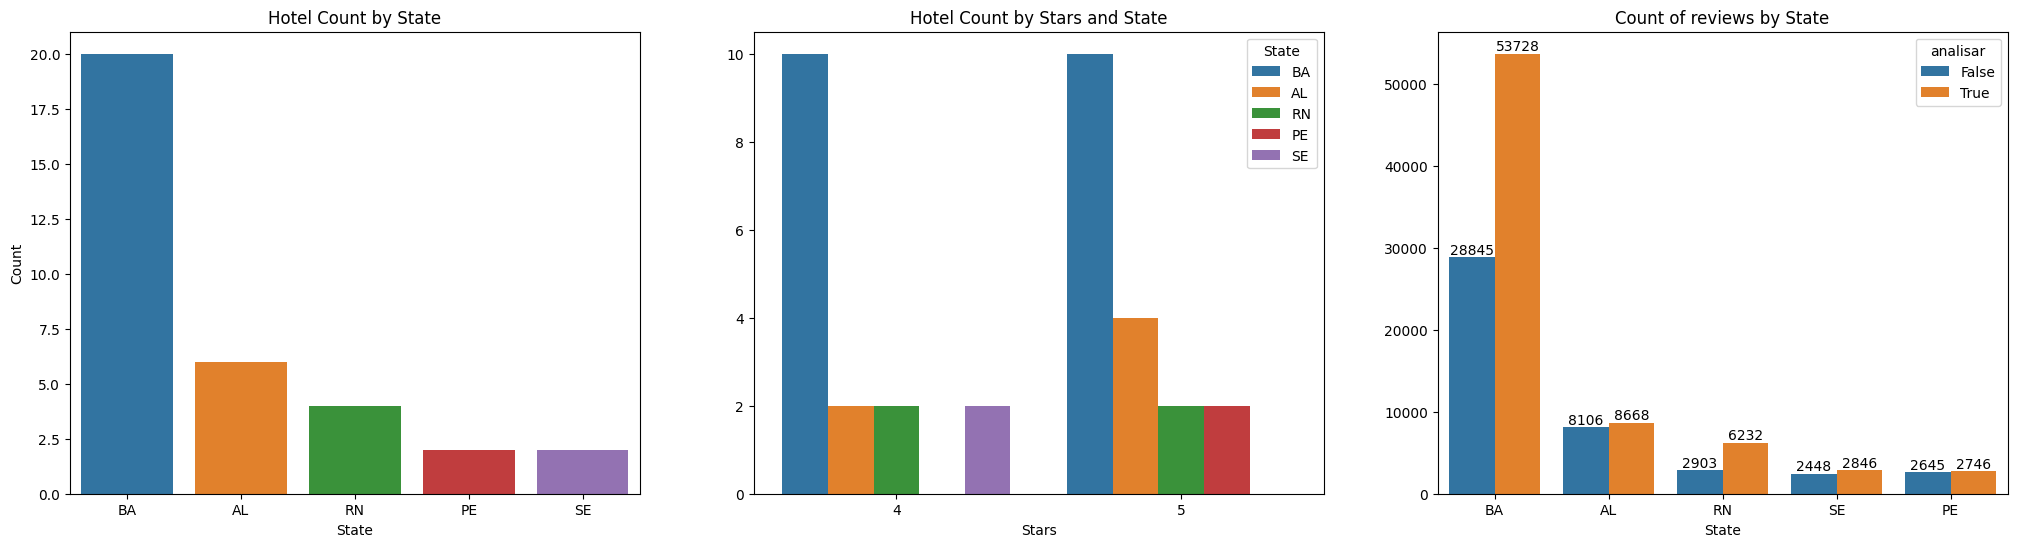

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
state_counts = hotels_metadados.groupby(['state', 'analisar'])['counts'].sum().reset_index().sort_values('counts', ascending=False)

sns.barplot(data=state_counts, x='state', hue='analisar', y='counts', ax=axes[2])
axes[2].set_title('Count of reviews by State')
axes[2].set_xlabel('State')
axes[2].set_ylabel('')

sns.countplot(data=hotels_metadados, x='state', ax=axes[0])
axes[0].set_title('Hotel Count by State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Count')

sns.countplot(data=hotels_metadados, x='stars', hue='state', ax=axes[1])
axes[1].set_title('Hotel Count by Stars and State')
axes[1].set_xlabel('Stars')
axes[1].set_ylabel('')
axes[1].legend(title='State')

# Add count values on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom')
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plots
plt.show()

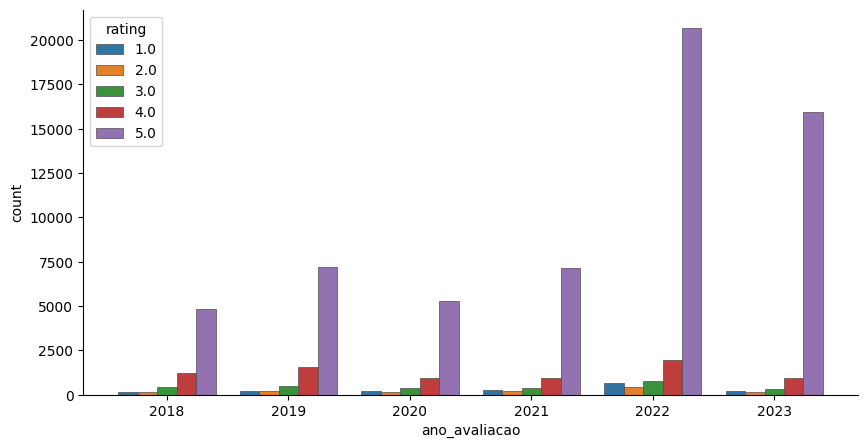

In [65]:
f, ax = plt.subplots(figsize=(10, 5))

sns.despine(f)

sns.countplot(
    x="ano_avaliacao",
    hue="rating",
    data=filtered_df,
    edgecolor=".3",
    linewidth=.5,
)
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.autoscale()
plt.show()

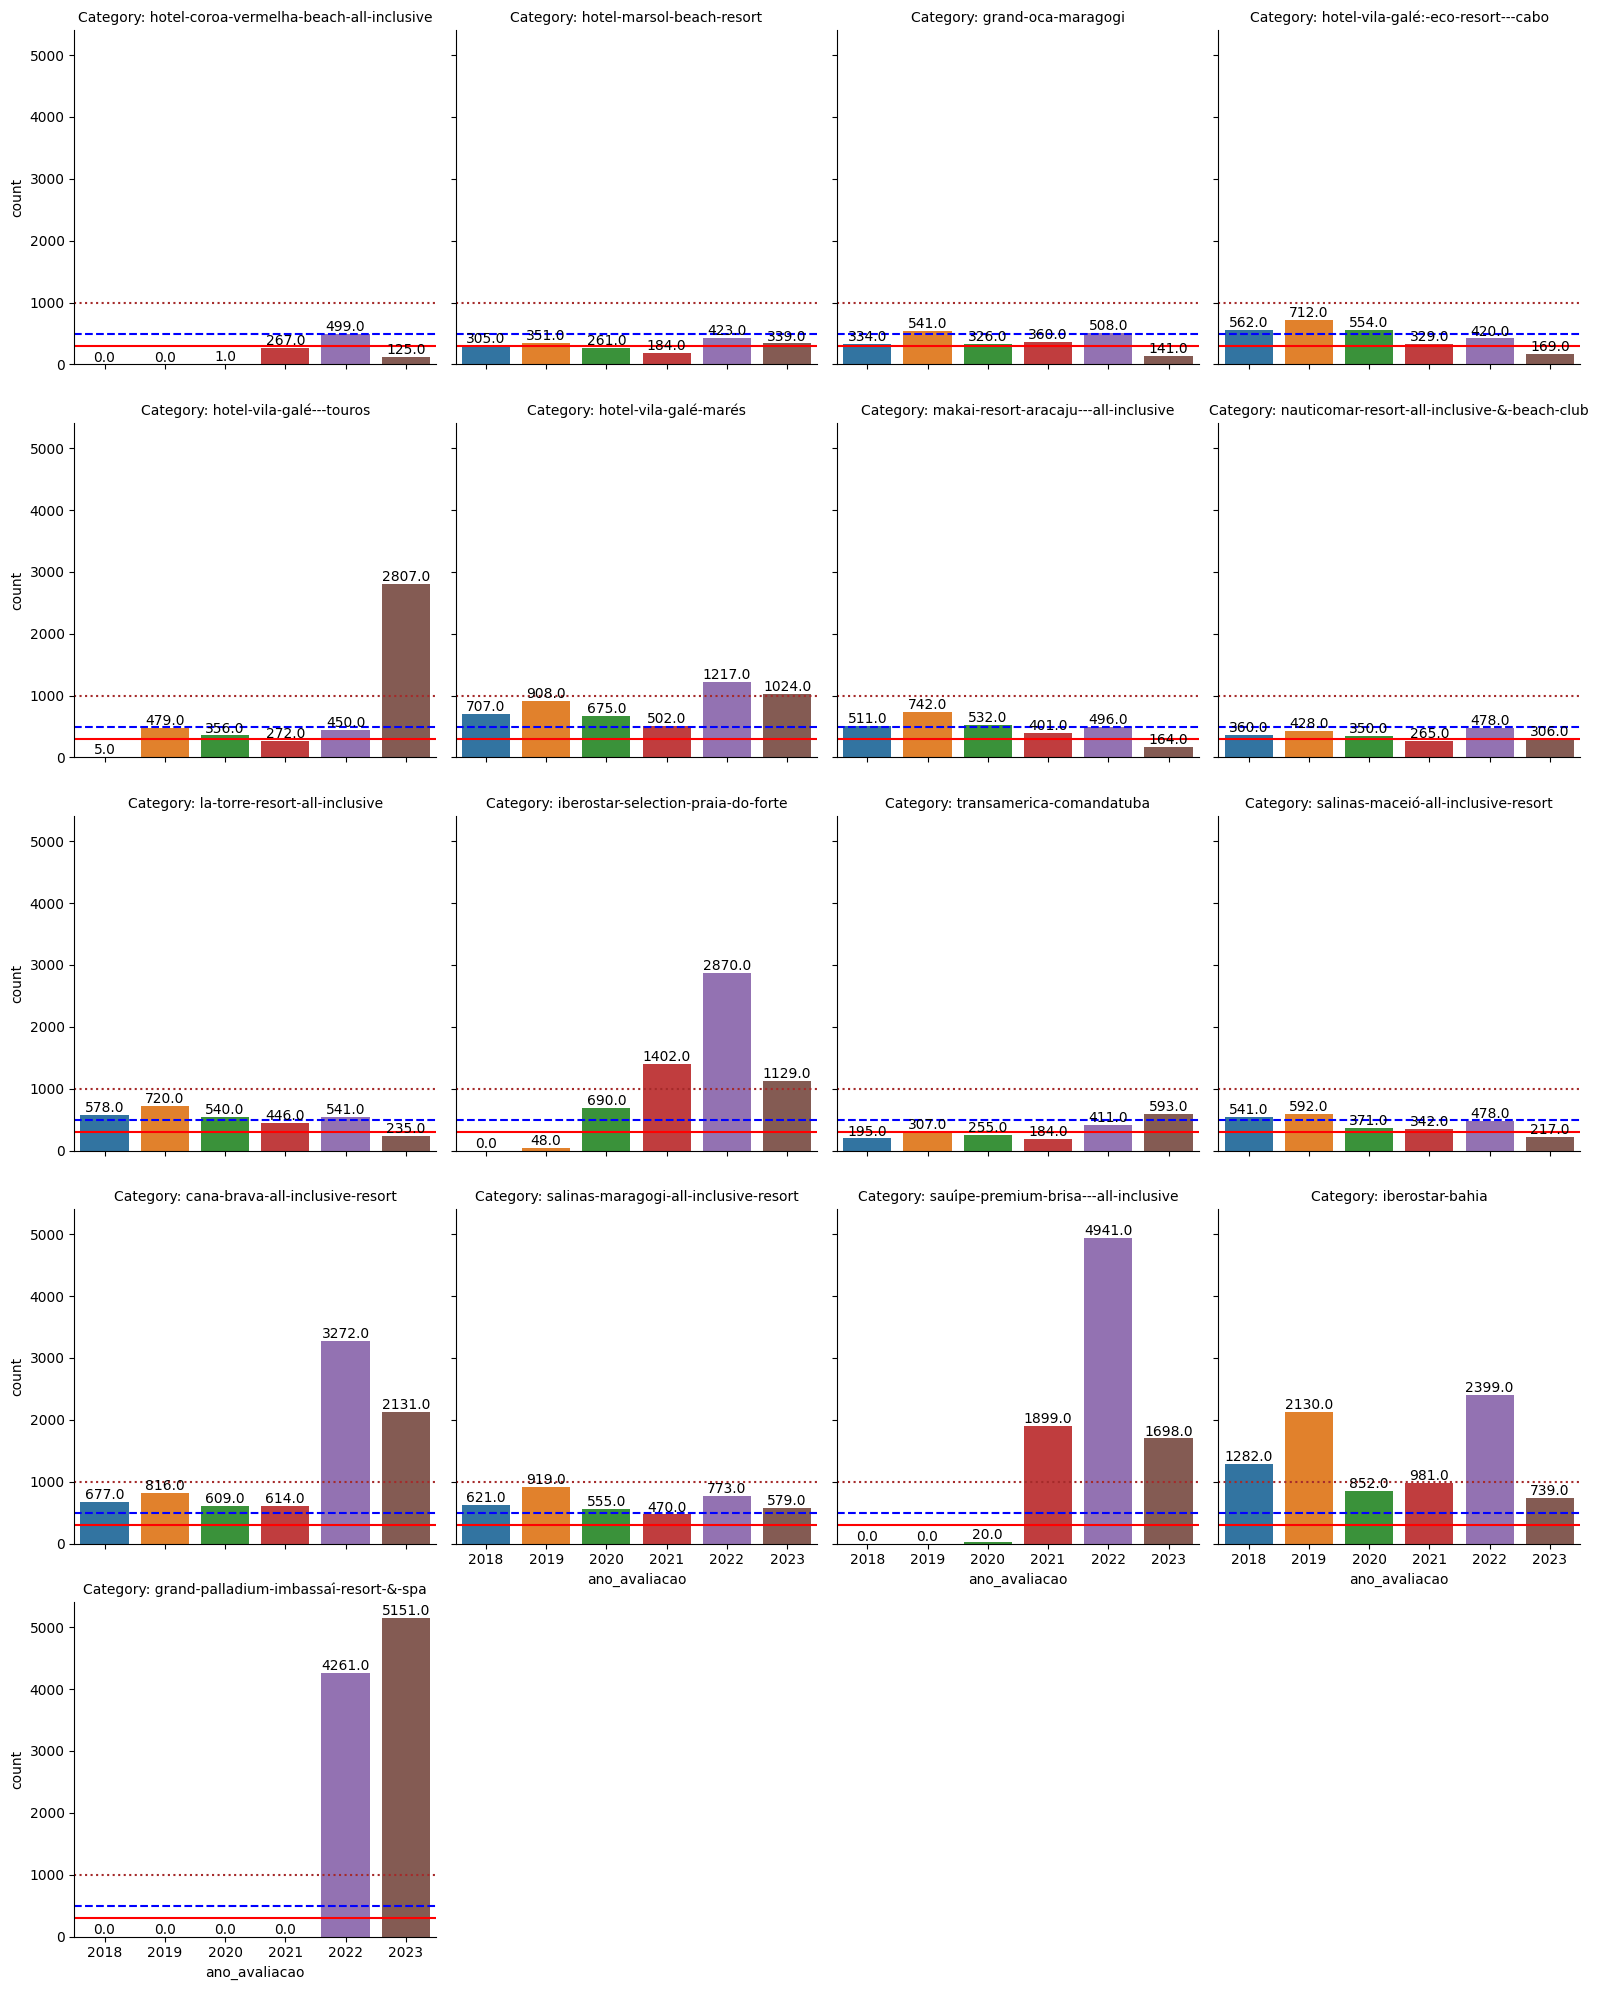

In [83]:
# Create countplot with subplots
g = sns.catplot(
    x="ano_avaliacao",
    col="source",
    data=filtered_df,
    col_wrap=4,
    kind='count',
    height=4,
    aspect=1,
)

# Iterate over each subplot
for ax in g.axes.flat:
    # Iterate over each bar in the subplot
    for p in ax.patches:
        # Get the count value of the bar
        count = p.get_height()
        # Add the count value as text annotation
        ax.annotate(count, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                    xytext=(0, 5), textcoords='offset points')
    ax.axhline(y=300, color='red', linestyle='-')
    ax.axhline(y=500, color='blue', linestyle='--')
    ax.axhline(y=1000, color='brown', linestyle=':')

# Set titles for each subplot
g.set_titles("Category: {col_name}")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# hotel-coroa-vermelha-beach-all-inclusive 18 / 19 / 20
# hotel-vila-galé---touros 18
# iberostar-selection-praia-do-forte 18
# sauípe-premium-brisa---all-inclusive 18/19/20
# grand-palladium-imbassaí-resort-&-spa 18/19/20/21

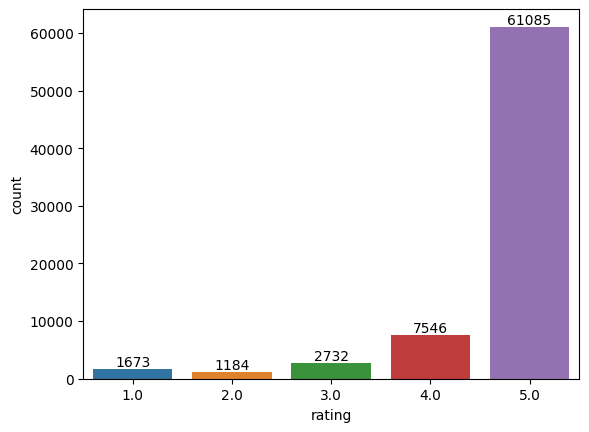

In [84]:
sns.countplot(x="rating", data=filtered_df)
# Add count values on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom')
plt.show()

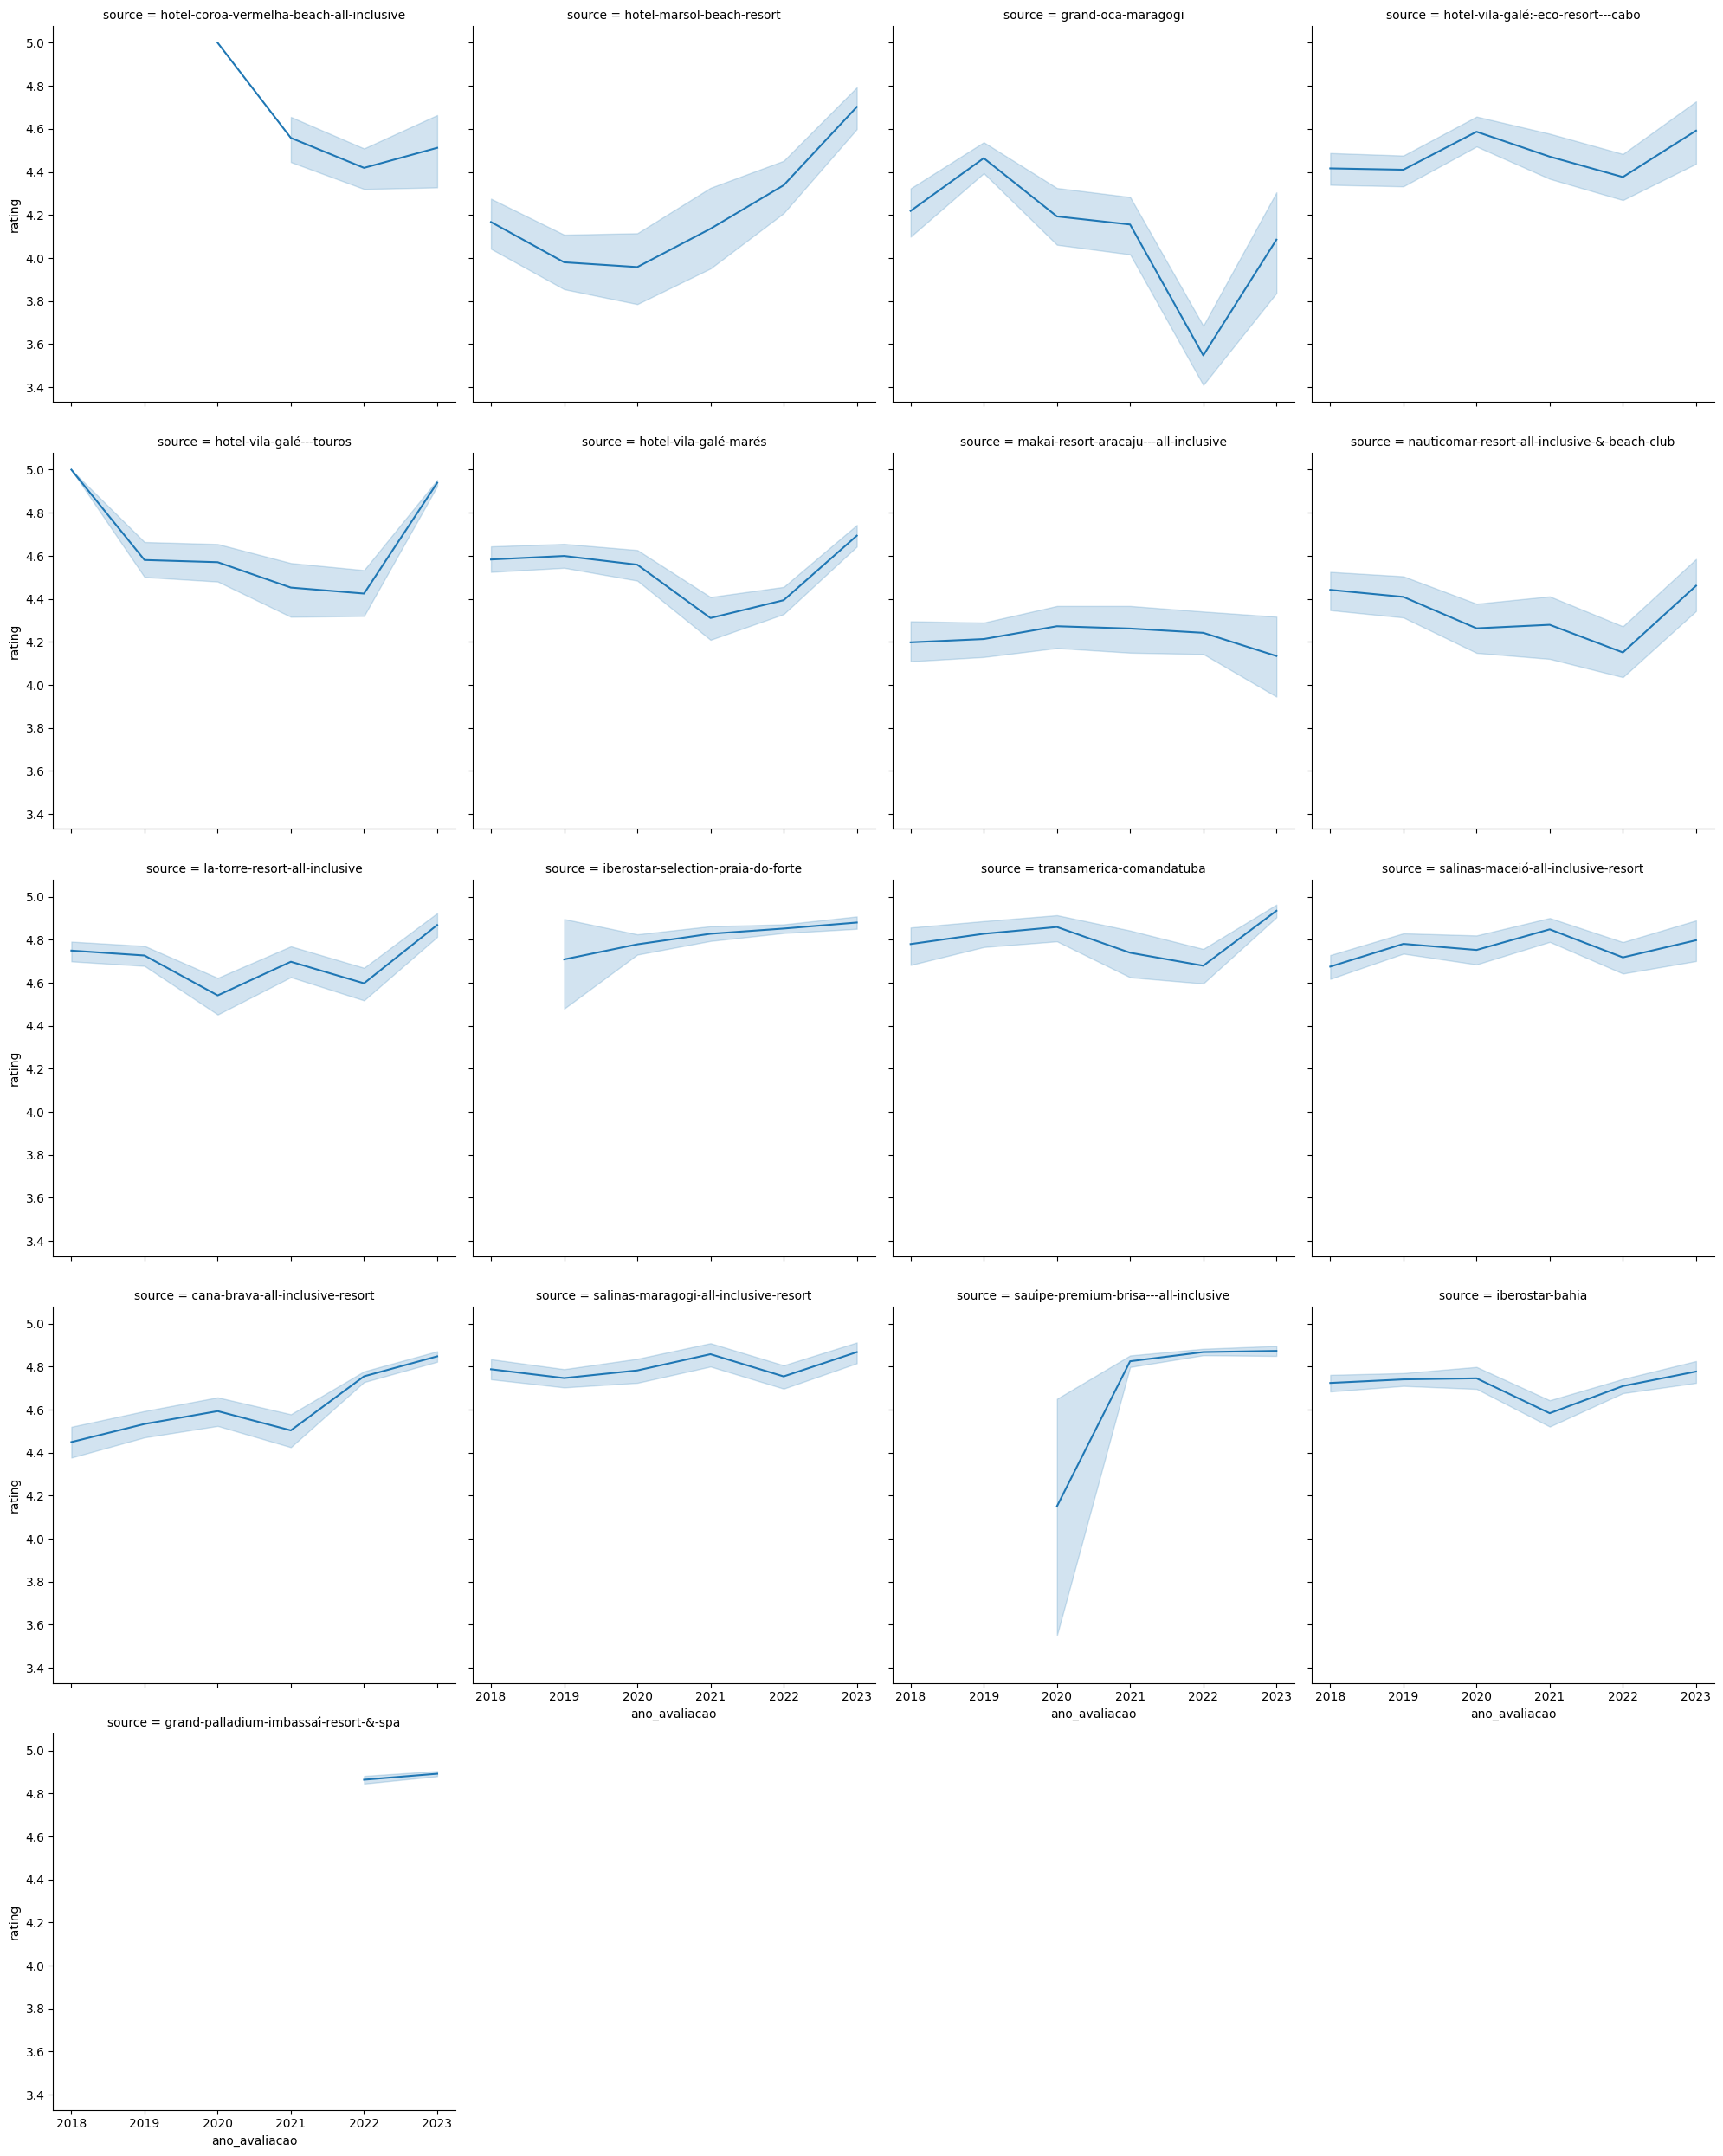

In [85]:
sns.relplot(
    x='ano_avaliacao',
    y='rating',
    col='source',
    kind="line",
    col_wrap=4,
    data=filtered_df,
)
plt.show()

In [ ]:
filtered_df[['rating', 'text', 'data_avaliacao', 'user_is_local_guide', 'user_reviews']].head()

,rating,text,data_avaliacao,user_is_local_guide,user_reviews
0,5.0,Um dos melhores hoteis all inclusive de Porto ...,2023-07-06,False,5
3,5.0,"Atendimento de primeira qualidade, lugar super...",2023-07-06,True,73
4,5.0,Ótimo lugar recomendo a todos,2023-07-05,True,10
7,4.0,"Bom dia, é um hotel ALL incluso razoável pois ...",2023-07-03,False,59
9,4.0,Foi muito legal ter ido ao Coroa Vermelha Reso...,2023-06-30,True,204


<Figure size 1000x500 with 0 Axes>

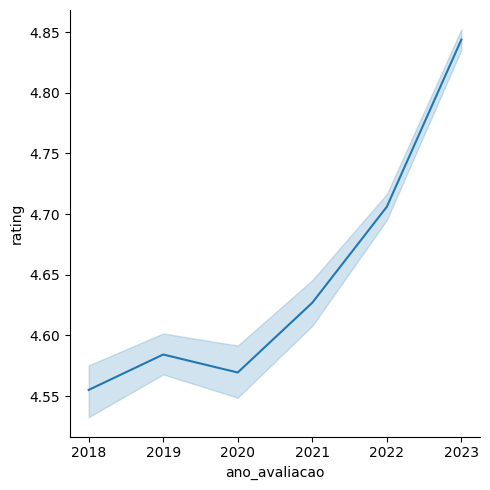

In [ ]:
plt.figure(figsize=(10,5))
sns.relplot(x='ano_avaliacao', y='rating', kind="line", data=filtered_df)

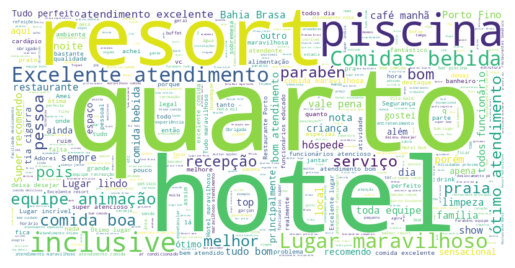

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

# Concatenar todos os textos em uma única string
texto = ' '.join(filtered_df['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)

# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))

# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar um objeto WordCloud com as configurações desejadas
wc = WordCloud(background_color='white', max_words=1000, width=800, height=400)

# Gerar a nuvem de palavras
nuvem = wc.generate(texto_sem_stopwords)

# Exibir a nuvem de palavras
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.show()

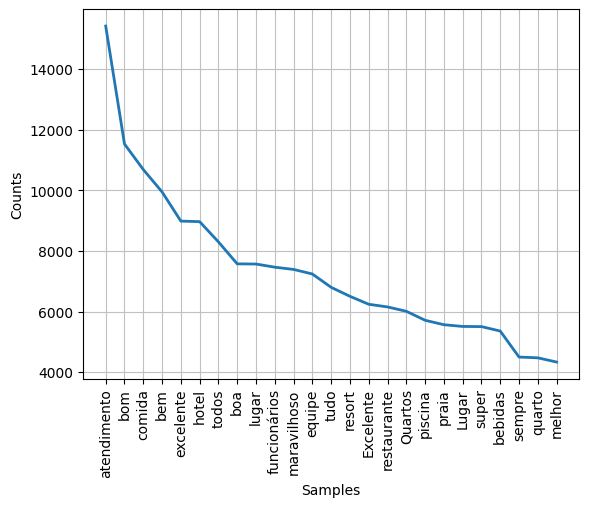

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

contagem.plot(25)

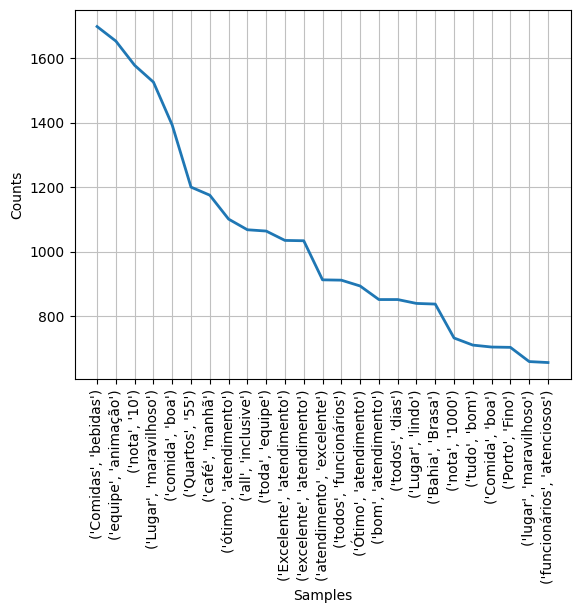

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
#Create your bigrams
bgs = nltk.bigrams(palavras)

#compute frequency distribution for all the bigrams in the text
fdist = FreqDist(bgs)
fdist.plot(25)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2018
filter = (filtered_df['source']  == 'grand-oca-maragogi') & (filtered_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(filtered_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2018= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2018['year'] = 2018
p2018

,word,frequency,year
0,Adorei,2,2018
1,Lugar,44,2018
2,bonito,9,2018
3,lazer,4,2018
4,fantástico,6,2018
...,...,...,...
1898,letra,1,2018
1899,FRACO,1,2018
1900,julho,1,2018
1901,2017,1,2018


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2019
filter = (filtered_df['source']  == 'grand-oca-maragogi') & (filtered_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(filtered_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2019= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2019['year'] = ano
p2019

,word,frequency,year
0,Resort,40,2019
1,lindíssimo,2,2019
2,natureza,5,2019
3,exuberante,2,2019
4,praia,132,2019
...,...,...,...
2836,perguntas,1,2019
2837,Haa,1,2019
2838,médico,1,2019
2839,assistência,1,2019


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2020
filter = (filtered_df['source']  == 'grand-oca-maragogi') & (filtered_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(filtered_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2020= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2020['year'] = ano
p2020

,word,frequency,year
0,deixou,3,2020
1,desejar,16,2020
2,vários,3,2020
3,itens,2,2020
4,grande,8,2020
...,...,...,...
2478,Comi,1,2020
2479,50,1,2020
2480,fikei,1,2020
2481,gastei,1,2020


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2021
filter = (filtered_df['source']  == 'grand-oca-maragogi') & (filtered_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(filtered_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2021= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2021['year'] = ano
p2021

,word,frequency,year
0,Pode,2,2021
1,melhor,34,2021
2,atendimento,64,2021
3,comida,84,2021
4,drinks,14,2021
...,...,...,...
2718,repetia,1,2021
2719,Suco,1,2021
2720,tematico,1,2021
2721,topso,1,2021


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2022
filter = (filtered_df['source']  == 'grand-oca-maragogi') & (filtered_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(filtered_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2022= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2022['year'] = ano
p2022

,word,frequency,year
0,resort,138,2022
1,bonito,25,2022
2,infraestrutura,6,2022
3,boa,93,2022
4,tanto,26,2022
...,...,...,...
5056,corrermos,1,2022
5057,Sistema,1,2022
5058,mudarem,1,2022
5059,Magnífica,1,2022


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2023
filter = (filtered_df['source']  == 'grand-oca-maragogi') & (filtered_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(filtered_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2023= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2023['year'] = ano
p2023

,word,frequency,year
0,PONTOS,1,2023
1,NEGATIVOS,1,2023
2,1º,1,2023
3,local,17,2023
4,praiano,1,2023
...,...,...,...
2406,absurdamente,1,2023
2407,caros,1,2023
2408,sim,1,2023
2409,pro,1,2023


In [ ]:
pd.concat([p2018, p2019,p2020,p2021,p2022, p2023]).sort_values(by=['frequency', 'year'], ascending=[False, False])

,word,frequency,year
8,praia,206,2022
56,comida,186,2022
53,bem,140,2022
0,resort,138,2022
83,hotel,136,2022
...,...,...,...
1898,letra,1,2018
1899,FRACO,1,2018
1900,julho,1,2018
1901,2017,1,2018


import numpy as np
from google.colab import autoviz
df_6522681536489128879 = autoviz.get_registered_df('df_6522681536489128879')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_6522681536489128879, *['frequency'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2607580816584378080 = autoviz.get_registered_df('df_2607580816584378080')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_2607580816584378080, *['frequency'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4223332360937321147 = autoviz.get_registered_df('df_4223332360937321147')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_4223332360937321147, *['year', 'frequency', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_3564807319811931954 = autoviz.get_registered_df('df_3564807319811931954')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_3564807319811931954, *['year', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_5726744807775728897 = autoviz.get_registered_df('df_5726744807775728897')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_5726744807775728897, *['frequency'], **{})
chart

import numpy as np
from google.colab import autoviz
df_502136154197951750 = autoviz.get_registered_df('df_502136154197951750')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_502136154197951750, *['frequency'], **{})
chart

import numpy as np
from google.colab import autoviz
df_5633874680182319892 = autoviz.get_registered_df('df_5633874680182319892')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_5633874680182319892, *['year', 'frequency', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_1319717843529595036 = autoviz.get_registered_df('df_1319717843529595036')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_1319717843529595036, *['year', 'count()', None], **{})
chart

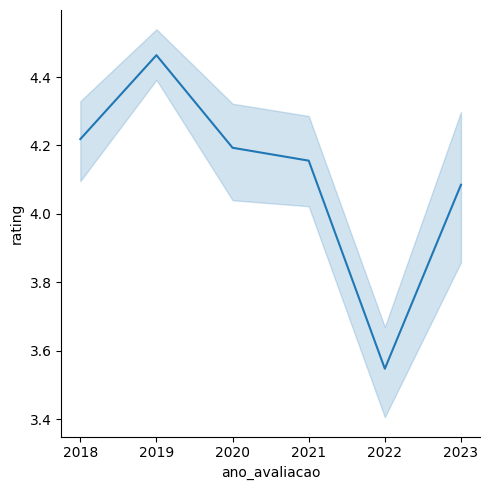

In [ ]:
sns.relplot(x='ano_avaliacao', y='rating', kind="line", data=filtered_df[filtered_df['source']  == 'grand-oca-maragogi'])


# bert

https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0

https://sol.sbc.org.br/index.php/stil/article/view/17784

https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [ ]:
!nvidia-smi

Fri Jun 23 03:40:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.4 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, pipeline

In [ ]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [ ]:
nlp = pipeline("sentense-classification", model=model, tokenizer=tokenizer)

KeyError: ignored

In [ ]:
nlp("Olá, meu cachorro ÉUMDeus")

[{'label': 'LABEL_0', 'score': 0.5444574952125549}]

In [ ]:
classifications = [model.config.id2label[output] for output in [1,0]]
print(classifications)

['LABEL_1', 'LABEL_0']


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

input_ids = tokenizer("Olá, meu cachorro é uma gracinha", add_special_tokens=True)  # Batch size 1
outputs = model(input_ids).logits

classifications = np.argmax(outputs, axis=1)
print(classifications)

AttributeError: ignored

In [ ]:
classifications = [model.config.id2label[output] for output in classifications]
print(classifications)

tensor(0.6474, grad_fn=<NllLossBackward0>)

In [ ]:
logits

tensor([[[ 0.0052,  0.2779],
         [-0.2616,  0.0519],
         [-0.4440,  0.0658],
         [-0.3884,  0.0534],
         [ 0.0137,  0.3454],
         [ 0.0459, -0.1442],
         [ 0.0415,  0.5969],
         [-0.0696,  0.5114],
         [-0.1732,  0.1848],
         [ 0.0758,  0.0475],
         [-0.0493,  0.1323],
         [ 0.0087,  0.2787]]], grad_fn=<ViewBackward0>)

In [ ]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = BertForTokenClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)

input_ids = torch.tensor(tokenizer.encode("Olá, meu cachorro é uma gracinha", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
labels = torch.tensor([1] * input_ids.size(1)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids, labels=labels)

logits = outputs.logits

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

In [ ]:
def to_sentiment(rating):
  rating = float(rating)
  if rating < 3:
    return 0
  elif rating > 4:
    return 2
  else:
    return 1

df['sentiment'] = df.rating.apply(to_sentiment)
df.head()

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
ax= sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
%mkdir -p gdrive/MyDrive/tcc/bert
file_csv_data = 'gdrive/MyDrive/tcc/bert/reviews.csv'
df.to_csv(file_csv_data, index=None, header=True)

In [ ]:
sample_txt = df.loc[1]['text']
sample_txt

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=45,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

In [ ]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

In [ ]:
# deprecated sns.distplot(token_lens)
sns.histplot(token_lens,
             kde=True,
             stat="density",
             kde_kws=dict(cut=3),
             alpha=.4,
             edgecolor=(1, 1, 1, .4),
             )
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [ ]:
max(token_lens)

In [ ]:
MAX_LEN = 512

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
len(train_data_loader)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
class SentimentClassifier(torch.nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = torch.nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


In [ ]:
history

In [ ]:
history['train_acc']

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))


In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# 08

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import pipeline

model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
classifier = pipeline('sentiment-analysis', model=model_path, tokenizer=model_path)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
filtered_df['sentiment'] = filtered_df['text'].apply(lambda x: classifier(x).label)

NameError: ignored

In [ ]:

sentences = [
  "Gostei muito do vídeo!",
  "Não estou feliz com os resultados."
]

result = classifier("Gostei muito do vídeo!")

AttributeError: ignored

In [ ]:
result

[{'label': 'positive', 'score': 0.9314153790473938}]